Finance complaint project

Feature engineering and model Training

In [1]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
#imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize,FreqDist
import string

In [3]:
df = pd.read_parquet('complaints.parquet')


As per the final report of EDA some feature can be removed

In [4]:
null_values = df.isnull().sum().div(df.shape[0]).mul(100).to_frame().sort_values(0,ascending=False)
null_values

,0
Tags,89.596489
Consumer_disputed,81.345413
Consumer_complaint_narrative,63.743834
Company_public_response,53.594397
consumer_consent_provided,21.896375
Sub-issue,17.414319
Sub-product,5.712515
State,1.050191
ZIP_code,0.733527
Company_response_to_consumer,0.000121


In [5]:
df['consumer_consent_provided'].unique()

array([None, 'Consent provided', 'Consent not provided', 'Other',
       'Consent withdrawn'], dtype=object)

N/A: Consumers did not have the option to publish their consumer complaint narrative or the complaint was received before March 19, 2015.</br>
 Data populates in this field immediately.</br>
Other: Complaint does not meet criteria for narrative publication.Other: Complaint does not meet criteria for narrative publication.</br>



In [6]:
columns = ['Tags','Consumer_complaint_narrative','Company_public_response',
           'Complaint_ID','ZIP_code','Sub-issue','Company','Sub-product']
df.drop(columns,inplace=True,axis=1)

In [7]:
null_values = df.isnull().sum().div(df.shape[0]).mul(100).to_frame().sort_values(0,ascending=False)
null_values

,0
Consumer_disputed,81.345413
consumer_consent_provided,21.896375
State,1.050191
Company_response_to_consumer,0.000121
Date_received,0.000000
Product,0.000000
Issue,0.000000
Submitted_via,0.000000
Date_sent_to_company,0.000000
Timely_response,0.000000


If we drop null values from Consumer_disputed we can see have less null values in  consumer_consent_provided and State which can be replaced by simple imputer with mode strategy

Feature Extraction

In [8]:
df[['Date_received','Date_sent_to_company']].head(5)

,Date_received,Date_sent_to_company
0,2023-08-14,2023-08-14
1,2023-08-23,2023-08-23
2,2023-09-27,2023-09-27
3,2023-09-27,2023-09-27
4,2023-09-27,2023-09-27


Date_received is the complaint registered to the CFBP and Date_sent_to_company is date when complaint has been sent to the respective company

In [9]:
df['days_to_forward_complaint'] = pd.to_datetime(df.Date_sent_to_company) - pd.to_datetime(df.Date_received) 
df['days_to_forward_complaint'] = df['days_to_forward_complaint'].dt.days

In [10]:
df['days_to_forward_complaint']

0          0
1          0
2          0
3          0
4          0
          ..
4118864    0
4118865    0
4118866    1
4118867    0
4118868    0
Name: days_to_forward_complaint, Length: 4118869, dtype: int64

Since we extracted the feature from the  'Date_received' and 'Date_sent_to_company' column these columns are not required, we can drop them

In [11]:
df.drop(['Date_received','Date_sent_to_company'],axis=1,inplace=True)

For Model to reduce computation time we can use sample of the data for the model but before that we will drop the null and save the file

In [12]:
df_cleaned = df.dropna(subset=['Consumer_disputed'])



df_cleaned.to_csv('complaints_7.csv', index=False)

In [13]:
data = pd.read_csv('complaints_7.csv')
data.head()

,Product,Issue,State,consumer_consent_provided,Submitted_via,Company_response_to_consumer,Timely_response,Consumer_disputed,days_to_forward_complaint
0,Bank account or service,"Account opening, closing, or management",NaN,NaN,Referral,Closed with explanation,Yes,Yes,4
1,Mortgage,"Loan modification,collection,foreclosure",FL,NaN,Phone,Closed with explanation,Yes,No,0
2,Mortgage,"Loan modification,collection,foreclosure",FL,NaN,Web,Closed with non-monetary relief,Yes,No,1
3,Mortgage,"Loan modification,collection,foreclosure",CA,Consent not provided,Web,Closed with explanation,Yes,Yes,0
4,Credit card,Billing statement,MD,Consent not provided,Web,Closed with explanation,Yes,No,2


In [14]:
data.isnull().sum()

Product                              0
Issue                                0
State                             5650
consumer_consent_provided       470521
Submitted_via                        0
Company_response_to_consumer         0
Timely_response                      0
Consumer_disputed                    0
days_to_forward_complaint            0
dtype: int64

In [15]:
data.shape

(768358, 9)

In [16]:
df1 = data.groupby('Consumer_disputed').sample(n=50000)
df1.reset_index(inplace=True)

Text Processing</br>
For Vectorization
<li>TFIDF</li>
<li>CountVectorizer</li>
<li>NLTK/Scipy Library</li>
<li>Pretrained Glove</li>




Here we can use TFIDF to process

Steps for text processing
<li>Remove Punctuation</li>
<li>Remove Stop Words</li>
<li>Lower casing</li>
<li>Tokenization</li>
<li>Stemming/Lemmatization</li>

<li>issue columnhas text which has to be preprocessed.</li>
<li>The text needs to be transformed into vectors so as the algorithms will be able to make predicitons. in this case we use the Term
Frequency-Inverse Document Freuency(TFIDF) weight to evaluare how important a word is to a document in a collection of  documents
</li>
<li>After removing punctuation and lower casing the words, the importance of a word is determined in term of frequency.</li>

Create list of stop words which has to be removed

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lang_chain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
stopwords_list = stopwords.words('english')+list(string.punctuation)

Create Function to tokenize and lematize the teext columns

In [19]:
from nltk.stem import WordNetLemmatizer

In [20]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lang_chain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lang_chain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')

# Function to tokenize data and remove stopwords
def process_text(issue):
    # Create tokens
    tokens = nltk.word_tokenize(issue)

    # Remove common stopwords
    stopwords_removed = [word for word in tokens if word.lower() not in stopwords.words('english')]
    return stopwords_removed

# Concatenate the string
def concat_strings(words_list):
    concat_words = ''
    for word in words_list:
        concat_words += word + ' '
    return concat_words.strip()

# Function to lemmatize words and merge each complaint into a single space-separated string
lemm = WordNetLemmatizer()

def lemmatizer_concat(words_list):
    # Remove any NaNs
    list_of_words = [i for i in words_list if i is not np.nan]

    # Lemmatize each word
    lemmatized_list = []
    for idx, word in enumerate(words_list):
        lemmatized_list.append(lemm.lemmatize(word))
    
    # Make the list into a single string with the words separated by ' '
    final_string = concat_strings(lemmatized_list)
    return final_string    




[nltk_data] Downloading package punkt to /home/lang_chain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lang_chain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Prepare data with text processing


In [22]:
df1.columns

Index(['index', 'Product', 'Issue', 'State', 'consumer_consent_provided',
       'Submitted_via', 'Company_response_to_consumer', 'Timely_response',
       'Consumer_disputed', 'days_to_forward_complaint'],
      dtype='object')

In [23]:
for i in range(len(df1)):
    text = process_text(df1['Issue'].loc[i])
    final_texts = lemmatizer_concat(text)
    df1.at[i, 'Issue'] = final_texts
    if i % 5000 == 0:
        print(f'Preprocessed Row Number {i}')


Preprocessed Row Number 0
Preprocessed Row Number 5000
Preprocessed Row Number 10000
Preprocessed Row Number 15000
Preprocessed Row Number 20000
Preprocessed Row Number 25000
Preprocessed Row Number 30000
Preprocessed Row Number 35000
Preprocessed Row Number 40000
Preprocessed Row Number 45000
Preprocessed Row Number 50000
Preprocessed Row Number 55000
Preprocessed Row Number 60000
Preprocessed Row Number 65000
Preprocessed Row Number 70000
Preprocessed Row Number 75000
Preprocessed Row Number 80000
Preprocessed Row Number 85000
Preprocessed Row Number 90000
Preprocessed Row Number 95000


Vectorizing the processed texts

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=None,strip_accents='unicode',analyzer='word',ngram_range=(1,2))

df_vect = tfidf.fit_transform(df1['Issue'])
feature_name = tfidf.get_feature_names_out()

In [25]:
feature_name

array(['account', 'account opening', 'account term', 'acct',
       'acct credited', 'acct wrong', 'action', 'adding', 'adding money',
       'advance', 'advance fee', 'advertising', 'advertising marketing',
       'amount', 'amount charged', 'amt', 'application',
       'application originator', 'application processing', 'applied',
       'applied loan', 'apply', 'apr', 'apr interest', 'arbitration',
       'atm', 'atm card', 'attempt', 'attempt collect', 'available',
       'available promised', 'balance', 'balance transfer', 'bank',
       'bank account', 'bank acct', 'bankruptcy', 'billing',
       'billing dispute', 'billing statement', 'broker', 'ca',
       'ca contact', 'ca repay', 'ca stop', 'cancelling',
       'cancelling account', 'card', 'card protection', 'cash',
       'cash advance', 'caused', 'caused fund', 'change', 'charge',
       'charge bank', 'charged', 'charged bank', 'charged fee',
       'charged received', 'check', 'closing', 'closing account',
       'closin

Data Preprocessing

Concat old data with vectorized data from issue text columns

In [26]:
df1 = pd.concat([df1, pd.DataFrame(df_vect.toarray())],axis=1)

After processing issue column as vectors, Now issue column can be removed

In [27]:
df1.drop(['Issue','index'],axis=1,inplace = True)

In [28]:
from sklearn.model_selection import train_test_split
x = df1.drop(['Consumer_disputed'],axis =1)
y = df1['Consumer_disputed']

In [29]:
x.shape

(100000, 352)

Initialize features for transformation

In [30]:
null_values = df1.isnull().sum().div(df1.shape[0]).mul(100).to_frame().sort_values(0,ascending=False)
null_values

,0
consumer_consent_provided,60.425
State,0.700
224,0.000
233,0.000
232,0.000
...,...
108,0.000
107,0.000
106,0.000
105,0.000


In [31]:
df1

,Product,State,consumer_consent_provided,Submitted_via,Company_response_to_consumer,Timely_response,Consumer_disputed,days_to_forward_complaint,0,1,...,335,336,337,338,339,340,341,342,343,344
0,Debt collection,CT,Consent provided,Web,Closed with explanation,Yes,No,0,0.0,0.0,...,0.0,0.0,0.469308,0.469308,0.0,0.0,0.0,0.0,0.0,0.0
1,Mortgage,MN,NaN,Referral,Closed with explanation,Yes,No,0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Debt collection,TN,NaN,Referral,Closed with explanation,Yes,No,5,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Debt collection,WA,Consent not provided,Web,Closed with explanation,Yes,No,8,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Credit reporting,CA,NaN,Web,Closed with non-monetary relief,Yes,No,0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Debt collection,VA,Consent provided,Web,Closed with explanation,Yes,Yes,0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
99996,Consumer Loan,FL,NaN,Web,Closed with explanation,Yes,Yes,0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
99997,Debt collection,TX,NaN,Postal mail,Closed with explanation,Yes,Yes,6,0.0,0.0,...,0.0,0.0,0.469308,0.469308,0.0,0.0,0.0,0.0,0.0,0.0
99998,Credit card,OH,Consent provided,Web,Closed with explanation,Yes,Yes,1,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df1.columns

Index([                     'Product',                        'State',
          'consumer_consent_provided',                'Submitted_via',
       'Company_response_to_consumer',              'Timely_response',
                  'Consumer_disputed',    'days_to_forward_complaint',
                                    0,                              1,
       ...
                                  335,                            336,
                                  337,                            338,
                                  339,                            340,
                                  341,                            342,
                                  343,                            344],
      dtype='object', length=353)

according to CFPB in consumer_consent_provided column the null value represent</br>
<!--  -->N/A: Consumers did not have the option to publish their consumer complaint narrative or the complaint was received before March 19, 2015. Data populates in this field immediately.

In [33]:
df1['consumer_consent_provided'].value_counts()

consumer_consent_provided
Consent provided        22631
Consent not provided    15780
Other                    1163
Consent withdrawn           1
Name: count, dtype: int64

In [34]:
df1.head()

,Product,State,consumer_consent_provided,Submitted_via,Company_response_to_consumer,Timely_response,Consumer_disputed,days_to_forward_complaint,0,1,...,335,336,337,338,339,340,341,342,343,344
0,Debt collection,CT,Consent provided,Web,Closed with explanation,Yes,No,0,0.0,0.0,...,0.0,0.0,0.469308,0.469308,0.0,0.0,0.0,0.0,0.0,0.0
1,Mortgage,MN,NaN,Referral,Closed with explanation,Yes,No,0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Debt collection,TN,NaN,Referral,Closed with explanation,Yes,No,5,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Debt collection,WA,Consent not provided,Web,Closed with explanation,Yes,No,8,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Credit reporting,CA,NaN,Web,Closed with non-monetary relief,Yes,No,0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:

x['consumer_consent_provided'] .fillna('Not Applicable', inplace=True)


In [55]:
x['consumer_consent_provided'].value_counts()

consumer_consent_provided
Not Applicable          60425
Consent provided        22631
Consent not provided    15780
Other                    1163
Consent withdrawn           1
Name: count, dtype: int64

In [56]:
null_values = x.isnull().sum().div(x.shape[0]).mul(100).to_frame().sort_values(0,ascending=False)
null_values

,0
State,0.7
Product,0.0
233,0.0
232,0.0
231,0.0
...,...
108,0.0
107,0.0
106,0.0
105,0.0


In [45]:
binary_feature = ['Product','State','Submitted_via','Company_response_to_consumer']
#for onehot encoder
one_hot_features = ['consumer_consent_provided','Timely_response','State']

In [78]:

numerical_feature = [feature for feature in x.columns if x[feature].dtypes != 'O']


In [79]:
numerical_feature

['days_to_forward_complaint',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',


In [75]:
rename_dict = {feature: str(feature) for feature in numerical_feature if isinstance(feature, int)}
rename_dict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '10',
 11: '11',
 12: '12',
 13: '13',
 14: '14',
 15: '15',
 16: '16',
 17: '17',
 18: '18',
 19: '19',
 20: '20',
 21: '21',
 22: '22',
 23: '23',
 24: '24',
 25: '25',
 26: '26',
 27: '27',
 28: '28',
 29: '29',
 30: '30',
 31: '31',
 32: '32',
 33: '33',
 34: '34',
 35: '35',
 36: '36',
 37: '37',
 38: '38',
 39: '39',
 40: '40',
 41: '41',
 42: '42',
 43: '43',
 44: '44',
 45: '45',
 46: '46',
 47: '47',
 48: '48',
 49: '49',
 50: '50',
 51: '51',
 52: '52',
 53: '53',
 54: '54',
 55: '55',
 56: '56',
 57: '57',
 58: '58',
 59: '59',
 60: '60',
 61: '61',
 62: '62',
 63: '63',
 64: '64',
 65: '65',
 66: '66',
 67: '67',
 68: '68',
 69: '69',
 70: '70',
 71: '71',
 72: '72',
 73: '73',
 74: '74',
 75: '75',
 76: '76',
 77: '77',
 78: '78',
 79: '79',
 80: '80',
 81: '81',
 82: '82',
 83: '83',
 84: '84',
 85: '85',
 86: '86',
 87: '87',
 88: '88',
 89: '89',
 90: '90',
 91: '91',
 92: '92

In [76]:
rename_dict = {feature: str(feature) for feature in numerical_feature if isinstance(feature, int)}

# Rename the columns in the DataFrame
x = x.rename(columns=rename_dict)

Create columnTransformer for transformation

In [63]:
null_feature = [feature for feature in x.columns if x[feature].isnull().sum()>0]
null_feature

['State']

In [80]:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

onehot_encoder_pipeline = Pipeline(steps=[
    ('SimpleImputer',SimpleImputer(strategy='most_frequent')),
    ('OneHot_encoder',OneHotEncoder())

])

binary_encoder_pipeline = Pipeline(steps=[
    ('SimpleImputer',SimpleImputer(strategy='most_frequent')),
    ('BinaryEncoder',ce.BinaryEncoder())

])

numeric_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

#getting data pre processor object
preprocessor = ColumnTransformer(
    [
        ("Categorical_Pipeline",onehot_encoder_pipeline,one_hot_features),
        ("Binary_encoder_pipeline",binary_encoder_pipeline,binary_feature),
        ("Numeric_Pipeline",numeric_pipeline,numerical_feature)
    ]
    ,remainder='passthrough'
)



Transforming the data for modelling

In [81]:
#fit transform the train data
X = preprocessor.fit_transform(x)

In [84]:
y = np.where(y.values=='Yes',0,1)

In [85]:
y

array([1, 1, 1, ..., 0, 0, 0])

Handling  imbalanced dataset

handling  imbalanced Target Variable.
<li> Synthetic Minority Oversampling Techniques or SMOTE is another technique to oversample the minority class. simply adding the duplicate records class often don't add ay new information to the model.</li>
<li> SMOTE is one of the famous oversampling techniques and is very efficient in handling class imbalance. The idea is to combine SMOTE with some undersampling techniques(ENN,Tomek) to increase the efficiency of handling the imbalanced dataset</li>

In [86]:

from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
#fit the model to generate the data
X_res,y_res = smt.fit_resample(X,y)


/home/lang_chain/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Model Selection

Here we should understand the Various Classification models with default values from these models we can choose 4 highest accuracy scores and proceed with HyperParameter Tuning 

In [87]:
#functioin which returns all the evaluation metrics for classification model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def evaluate_clf(true, predicted):
    acc = accuracy_score(true,predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    return acc,f1,precision,recall,roc_auc

In [93]:
#initializing models which are required for model selection
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Create a dictionary of classifiers
classifier = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(),
    'K-Neighbours classifier': KNeighborsClassifier(),
    'XGBoost classifier': XGBClassifier(),
    'CatBoosting classifier': CatBoostClassifier(),
    'AdaBoost classifier ': AdaBoostClassifier()
}


In [99]:
#create a function which can evaluate  models and return a report in Dataframe

def evaluate_models(X,y,models):
    '''
    This function takes in X and y and models dict as input
    It splits the data into Train test split
    Iterates through the given model dict and evaluate the metrics
    Returns: Dataframe which contains the report of all models metrics with cost
    '''
    #seperate dataset into train and test
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    models_list = []
    accuracy_list= []
    auc = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train,y_train) #train model

        #make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        #training set performance
        model_train_accuracy, model_train_f1,model_train_precision,model_train_recall,model_train_rocauc_score = evaluate_clf(y_train,y_train_pred)

        #test set performance
        model_test_accuracy, model_test_f1,model_test_precision,model_test_recall,model_test_rocauc_score = evaluate_clf(y_test,y_test_pred)


        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])
        accuracy_list.append(model_test_accuracy)


        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print("- F1 Score: {:.4f}".format(model_train_f1))
        print("- Precission: {:.4f}".format(model_train_precision))
        print("- Recall: {:.4f}".format(model_train_recall))
        print("- Roc AUC Score: {:.4f}".format(model_train_rocauc_score))

        print('------------------------------------------------------')

        print('Model performance for Test set')
        print("- Accuracy: {:.4f}".format(model_test_accuracy))
        print("- F1 Score: {:.4f}".format(model_test_f1))
        print("- Precission: {:.4f}".format(model_test_precision))
        print("- Recall: {:.4f}".format(model_test_recall))
        print("- Roc AUC Score: {:.4f}".format(model_test_rocauc_score))

        auc.append(model_test_rocauc_score)
        print('='*35)

        print('\n')


    report = pd.DataFrame(list(zip(models_list, accuracy_list)),
                      columns=['Model Name', 'Accuracy'])

    # Sort the DataFrame by accuracy in descending order
    report = report.sort_values(by=['Accuracy'], ascending=False)
    return report




Base report off all models with default parameters

In [100]:
base_report =  evaluate_models(X=X_res,y=y_res,models=classifier)

Random Forest
Model performance for Training set
- Accuracy: 0.7720
- F1 Score: 0.7624
- Precission: 0.7954
- Recall: 0.7320
- Roc AUC Score: 0.7720
------------------------------------------------------
Model performance for Test set
- Accuracy: 0.5713
- F1 Score: 0.5571
- Precission: 0.5775
- Recall: 0.5381
- Roc AUC Score: 0.5714


Decision Tree
Model performance for Training set
- Accuracy: 0.7721
- F1 Score: 0.7497
- Precission: 0.8306
- Recall: 0.6832
- Roc AUC Score: 0.7720
------------------------------------------------------
Model performance for Test set
- Accuracy: 0.5553
- F1 Score: 0.5170
- Precission: 0.5672
- Recall: 0.4750
- Roc AUC Score: 0.5555


Gradient Boosting
Model performance for Training set
- Accuracy: 0.5971
- F1 Score: 0.5363
- Precission: 0.6312
- Recall: 0.4662
- Roc AUC Score: 0.5970
------------------------------------------------------
Model performance for Test set
- Accuracy: 0.5991
- F1 Score: 0.5377
- Precission: 0.6369
- Recall: 0.4652
- Roc AUC S

/home/lang_chain/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Model performance for Training set
- Accuracy: 0.5898
- F1 Score: 0.5792
- Precission: 0.5942
- Recall: 0.5649
- Roc AUC Score: 0.5898
------------------------------------------------------
Model performance for Test set
- Accuracy: 0.5885
- F1 Score: 0.5760
- Precission: 0.5955
- Recall: 0.5577
- Roc AUC Score: 0.5886


K-Neighbours classifier
Model performance for Training set
- Accuracy: 0.6658
- F1 Score: 0.6646
- Precission: 0.6666
- Recall: 0.6626
- Roc AUC Score: 0.6658
------------------------------------------------------
Model performance for Test set
- Accuracy: 0.5558
- F1 Score: 0.5514
- Precission: 0.5582
- Recall: 0.5448
- Roc AUC Score: 0.5558


XGBoost classifier
Model performance for Training set
- Accuracy: 0.6274
- F1 Score: 0.5847
- Precission: 0.6600
- Recall: 0.5248
- Roc AUC Score: 0.6274
------------------------------------------------------
Model performance for Test set
- Accuracy: 0.5971
- F1 Score: 0.5517
- Precission: 0.6236
- Recall: 0

Report in DataFrame

In [101]:
base_report

,Model Name,Accuracy
6,CatBoosting classifier,0.604159
2,Gradient Boosting,0.599092
5,XGBoost classifier,0.597139
7,AdaBoost classifier,0.591175
3,Logistic Regression,0.588484
0,Random Forest,0.571278
4,K-Neighbours classifier,0.555814
1,Decision Tree,0.555286


here we can use CatBoost classifier for Hyper tuning

Hyperopt: Distributed Hyperparameter Optimization
<li>Hyperopt is a powerful library for hyperparameter optimization</li>
<li>Grid Search is exhaustive in case of Resources Usage</li>
<li>Random Forest is random, so we could miss the most important values. However, there is a superior method available through the Hyperopt package</li>

Search space is where Hyperopt relly gives us many sampling options
<li>for categorical parameters we have hp.choice</li>
<li>for integer we get hp.randit, hp.quniform, hp.qlognomal</li>
<li>for floats<, we have hp.normal,hp.uniform, hp.lognormal and np.loguniform/li>
<li>These are the most expensive sampling functionality out there</li>

We define Search space before runing optimization but we can't very complex parameters spaces

Hyperparameters tuning for Xgboost Model

This is a function to minimize that recieves hyperparameters values as input from the search space and returns the loss

In [102]:
#create an objective function for hyperopt

def XGB_objective(params):
    model = XGBClassifier(**params,n_jobs=-1)
    X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    return -acc

In [103]:
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

#define the search space
search_space = {
    'max_length':hp.quniform("max_length",3,10,1),
    'gamma':hp.uniform('gamma',1,9),
    'cosample_bytree': hp.uniform('cplsample_bytree',0.5,1),
    'min_child_weight': hp.quniform('min_child_weight',0,10,1),
    'n_estimators':100,
    'seed': 0
}

xgb_trails =Trials()

#using Fmin function to get best xgb_objective
best_xgb = fmin(
    fn = XGB_objective,
    space=search_space,
    algo=tpe.suggest,
    trials=xgb_trails,
    max_evals=10,
    rstate=np.random.default_rng()
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/lang_chain/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:55:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cosample_bytree", "max_length" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 1/10 [00:11<01:40, 11.21s/trial, best loss: -0.5991449833746767]

/home/lang_chain/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:55:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cosample_bytree", "max_length" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 2/10 [00:22<01:29, 11.20s/trial, best loss: -0.5992505409827413]

/home/lang_chain/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:56:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cosample_bytree", "max_length" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 3/10 [00:33<01:19, 11.33s/trial, best loss: -0.5992505409827413]

/home/lang_chain/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:56:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cosample_bytree", "max_length" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 4/10 [00:46<01:11, 11.97s/trial, best loss: -0.5992505409827413]

/home/lang_chain/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:56:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cosample_bytree", "max_length" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 5/10 [00:57<00:57, 11.47s/trial, best loss: -0.5992505409827413]

/home/lang_chain/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:56:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cosample_bytree", "max_length" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 6/10 [01:10<00:48, 12.18s/trial, best loss: -0.601467250752098] 

/home/lang_chain/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:56:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cosample_bytree", "max_length" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 7/10 [01:30<00:43, 14.63s/trial, best loss: -0.601467250752098]

/home/lang_chain/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:57:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cosample_bytree", "max_length" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 8/10 [01:41<00:26, 13.41s/trial, best loss: -0.601467250752098]

/home/lang_chain/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:57:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cosample_bytree", "max_length" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 9/10 [01:54<00:13, 13.27s/trial, best loss: -0.601467250752098]

/home/lang_chain/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:57:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "cosample_bytree", "max_length" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 10/10 [02:04<00:00, 12.45s/trial, best loss: -0.601467250752098]


The accuracy for XGboost is 60%

HyperParameter tuning for CatBoost model

In [104]:
def Catboost_objective(params):
    model = CatBoostClassifier(**params,verbose=False, thread_count=-1)
    X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    return -acc

In [107]:
#define the search space
search_space = {
    'learning_rate':hp.uniform("learning_rate",0.001,1),
    'depth':scope.int(hp.quniform('max_depth',2,10,1)),
    'iterations': scope.int(hp.quniform('iterations',50,1000,50)),
    'l2_leaf_reg':scope.int(hp.quniform('l2_leaf_reg',1,50,1))
}

cat_trails =Trials()

#using Fmin function to get best xgb_objective
best_cat = fmin(
    fn = Catboost_objective,
    space=search_space,
    algo=tpe.suggest,
    trials=cat_trails,
    max_evals=10,
    rstate=np.random.default_rng()
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [01:29<00:00,  8.93s/trial, best loss: -0.5997255502190321]


In [108]:
best_cat

{'iterations': 600.0,
 'l2_leaf_reg': 43.0,
 'learning_rate': 0.20177577848600178,
 'max_depth': 3.0}

In [109]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
model = CatBoostClassifier(**best_cat,verbose=False,thread_count=-1)
X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test,y_pred)

matrix = confusion_matrix(y_test,y_pred)
cm = ConfusionMatrixDisplay(matrix)


In [112]:
acc

0.5997255502190321

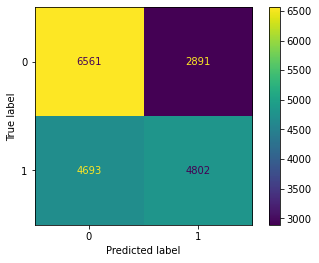

In [111]:
cm.plot()
plt.show()